<a href="https://colab.research.google.com/github/diegoflorescba/MentoriaCripto2022-Grupo2/blob/main/4tp_aprendizajeNoSupervisado/4tp_aprendizajeNoSupervisado_grupo_2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

isin# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 4 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de grandes cantidades de datos (activos en nuestro caso).

# 📖 ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en término de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I 

Una forma sencilla de predecir el comportamiento de los activos sería suponer que todos siguen el mismo modelo de aprendizaje automático y crear este modelo global para predecir los rendimientos de todos los activos. Sin embargo, es posible que ellos reaccionen de manera diferente a un conjunto de indicadores técnicos. Una forma de resolver este problema es crear un modelo diferente para grupos de activos que se espera que se comporten de manera similar.

Evaluen los siguientes algoritmos de clusterización. 

- Mean Shift.
- k-means. 
- Clustering Jerárquico 

¿Qué activos forman parte de cada cluster? ¿Encuentran alguna relación dentro de cada grupo?

## Parte II 

- Usar la medida de distancia dynamic time warping para agrupar por k-means y comparar con lo obtenido con la métrica euclídea ([link](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)). Comente los resultados.

## Opcional 

- Aplicar factores dinámicos para ver si las tasas de retorno se pueden resumir en uno o unos pocos constructos subyacentes ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_dfm_coincident.html))

# Fecha de entrega

- __Versión preliminar: 12/9__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

# Desarrollo

####Comenzaremos este entregable llamando a una base de datos que hemos trabajado previamente en informes anteriores. La misma comprende de los precios de apertura, cierre, máximo y mínimo de más de una decena de criptomonedas. 

In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

#clusters
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/diegoflorescba/MentoriaCripto2022-Grupo2/main/2tp_analisisYCuracion/Activos%20limpios%20con%20features%20-%202tp%20-%20Final.csv',index_col='Fecha')

####Armamos una función "status" la cual utilizaremos más adelante. A través de ella conoceremos información de la base de datos, como por ejemplo,valores nulos , cantidad de variables, información sobre las columnas de la misma, tipo de variables, entre otros. 

In [3]:
def status(data):

    data2=data 
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)

####De esta base de datos, armaremos uno nuevo, solo tomando aquellas columnas que consideramos de interés. En este caso son:
* "profit" el cual es la diferencia entre el valor de un activo entre dos períodos. Esto lo podemos interpretar como la ganancia o pérdida del valor monetario de este activo en dicho período. 
* "close" es el valor de cierre de la criptomoneda al terminar un período. Tomamos este valor y no otro ya que el close termina definiendo el valor real del activo al finalizar un período, este indica si el valor subió o bajó respecto al lapso anterior. 
* "active" es el conjunto de cripto activos que disponemos en la base de datos. 

In [4]:
columns_interesting = ['profit','close','active']
df_filter = df[columns_interesting]
df_filter

,profit,close,active
Fecha,,,
2019-01-01 03:00:00,1.250000,0.35073,XRPUSDT
2019-01-01 03:00:00,2.019584,133.36000,ETHUSDT
2019-01-01 03:00:00,0.702214,2.53830,EOSUSDT
2019-01-01 03:00:00,1.830491,0.04061,ADAUSDT
2019-01-01 03:00:00,1.311806,30.12000,LTCUSDT
...,...,...,...
2022-05-02 11:00:00,2.492522,30.84000,AXSUSDT
2022-05-02 11:00:00,0.330984,38840.00000,BTCUSDT
2022-05-02 11:00:00,1.110575,2.09400,EOSUSDT


In [5]:
df_filter.index = pd.to_datetime(df_filter.index)
df_filter

,profit,close,active
Fecha,,,
2019-01-01 03:00:00,1.250000,0.35073,XRPUSDT
2019-01-01 03:00:00,2.019584,133.36000,ETHUSDT
2019-01-01 03:00:00,0.702214,2.53830,EOSUSDT
2019-01-01 03:00:00,1.830491,0.04061,ADAUSDT
2019-01-01 03:00:00,1.311806,30.12000,LTCUSDT
...,...,...,...
2022-05-02 11:00:00,2.492522,30.84000,AXSUSDT
2022-05-02 11:00:00,0.330984,38840.00000,BTCUSDT
2022-05-02 11:00:00,1.110575,2.09400,EOSUSDT


#### Para poder explorar un poco mejor los cluster, agrupamos la recurrencia de cada activo. Actualmente tiene recurrencia de cada 4 horas, pasándolo a diaria, sacando la media tanto del close como la del profit.

In [6]:
contador = 0
for i in set(df_filter.active):
    aux = df_filter[df_filter.active == i]
    aux2 = aux.resample("d").mean()
    aux2['active'] = i
    if contador == 0:
        df_filter_daily = aux2.copy()
        contador += 1
    else:
        df_filter_daily = pd.concat([df_filter_daily, aux2])
        # df_filter_daily = df_filter_daily.dropna()

####Validamos que dentro de esta base de datos no se encuentren valores nulos (NaN).

In [7]:
status(df_filter_daily)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,profit,0,0.0,0,0.0,19392,float64
1,close,0,0.0,0,0.0,19132,float64
2,active,0,0.0,0,0.0,19,object


#### Una vez agrupado el set de datos por dia, se realiza el escalado por minimos y maximos por la columna close y profit, del 0 al 1 por cada activo. De esta manera podemos realizar cluster en base al rango y comportamiento de cada activo y no por el monto. Esto se debe a que el precio de los activos varían significativamente, teniendo algúnos cuyo valor unitario de es del orden de los centavos de dólar, mientras que otros como el Bitcoin cotizan en decenas de miles de dólarees

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
contador = 0
for i in set(df_filter_daily.active):
    aux = df_filter_daily[df_filter_daily.active == i]
    aux[['Scalar_close']] = scaler.fit_transform(aux[["close"]])
    aux[['Scalar_profit']] = scaler.fit_transform(aux[["profit"]])
    if contador == 0:
        df_filter_daily_scalar = aux.copy()
        contador += 1
    else:
        df_filter_daily_scalar = pd.concat([df_filter_daily_scalar, aux])
        # df_filter_daily_scalar = df_filter_daily.dropna()

#### Validamos que no queden valores nulos (nan) luego del proceso.

In [9]:
status(df_filter_daily_scalar)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,profit,0,0.0,0,0.00000,19392,float64
1,close,0,0.0,0,0.00000,19132,float64
2,active,0,0.0,0,0.00000,19,object
3,Scalar_close,0,0.0,19,0.00098,19264,float64
4,Scalar_profit,0,0.0,19,0.00098,19358,float64


#### Para poder evaluar de una manera mas visible se toma los 11 criptos con mayor volumen del mercado que analizamos en trabajos anteriores. Para ello, en el siguiente código quitaremos los activos menos comercializados y solo nos quedaremos con los anteriormente mencionados.

In [10]:
criptos = list(['AAVEUSDT', 'AXSUSDT', 'BCHUSDT', 'COMPUSDT', 'DOTUSDT'])
df_filter_daily_scalar_top = df_filter_daily_scalar[~df_filter_daily_scalar.active.isin(criptos)]

In [11]:
df_filter_daily_scalar_top

,profit,close,active,Scalar_close,Scalar_profit
Fecha,,,,,
2019-01-01,0.741439,5.056033,ETCUSDT,0.011935,0.573965
2019-01-02,0.291077,5.259117,ETCUSDT,0.013584,0.543731
2019-01-03,-0.884433,5.081650,ETCUSDT,0.012143,0.464817
2019-01-04,0.555060,5.082950,ETCUSDT,0.012154,0.561453
2019-01-05,-0.355123,5.112950,ETCUSDT,0.012397,0.500351
...,...,...,...,...,...
2022-04-28,0.190425,231.716667,XMRUSDT,0.443837,0.603384
2022-04-29,-0.982596,225.366667,XMRUSDT,0.429663,0.510476
2022-04-30,0.230592,224.883333,XMRUSDT,0.428584,0.606565


### Creamos un nuevo dataframe para dejar sin modificaciones el que ya agrupamos y escalamos.

In [12]:
# columns_interesting = ['Scalar_profit','profit','Scalar_close','close','active']
# df_pivot = df_filter_daily_scalar_top[columns_interesting]
df_pivot = df_filter_daily_scalar_top
df_pivot

,profit,close,active,Scalar_close,Scalar_profit
Fecha,,,,,
2019-01-01,0.741439,5.056033,ETCUSDT,0.011935,0.573965
2019-01-02,0.291077,5.259117,ETCUSDT,0.013584,0.543731
2019-01-03,-0.884433,5.081650,ETCUSDT,0.012143,0.464817
2019-01-04,0.555060,5.082950,ETCUSDT,0.012154,0.561453
2019-01-05,-0.355123,5.112950,ETCUSDT,0.012397,0.500351
...,...,...,...,...,...
2022-04-28,0.190425,231.716667,XMRUSDT,0.443837,0.603384
2022-04-29,-0.982596,225.366667,XMRUSDT,0.429663,0.510476
2022-04-30,0.230592,224.883333,XMRUSDT,0.428584,0.606565


#### Tomamos de todas las columnas solo el nombre del activo y el close escalado, para posteriormente utilizarlo para las ejecuciones y validaciones de los cluster.

In [13]:
df_pivot = df_pivot[['active','Scalar_close']]
df_pivot

,active,Scalar_close
Fecha,,
2019-01-01,ETCUSDT,0.011935
2019-01-02,ETCUSDT,0.013584
2019-01-03,ETCUSDT,0.012143
2019-01-04,ETCUSDT,0.012154
2019-01-05,ETCUSDT,0.012397
...,...,...
2022-04-28,XMRUSDT,0.443837
2022-04-29,XMRUSDT,0.429663
2022-04-30,XMRUSDT,0.428584


#### Realizamos el pivot de las columnas para que los diferentes activos sean clusterizados por el comportamiento

In [14]:
# df_kmeans = df_pivot[['active','Scalar_close']]
# df_kmeans = df_pivot
df_pivot = df_pivot.pivot(columns='active', values='Scalar_close')
df_pivot = df_pivot.reset_index()

#### Aplicamos la función "status" anteriormente mencionada a la base de datos ya pivotada. 

In [15]:
status(df_pivot)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Fecha,0,0.000000,0,0.000000,1218,datetime64[ns]
1,ADAUSDT,0,0.000000,1,0.000821,1208,float64
2,BNBUSDT,0,0.000000,1,0.000821,1216,float64
3,BTCUSDT,0,0.000000,1,0.000821,1218,float64
4,DASHUSDT,86,0.070608,1,0.000821,1119,float64
5,DOGEUSDT,185,0.151888,1,0.000821,1027,float64
6,EOSUSDT,0,0.000000,1,0.000821,1212,float64
7,ETCUSDT,0,0.000000,1,0.000821,1216,float64
8,ETHUSDT,0,0.000000,1,0.000821,1216,float64
9,LINKUSDT,15,0.012315,1,0.000821,1196,float64


#### Eliminamos valores en nulos por la diferencias de fecha de creacion de las diferentes criptomonedas y eliminamos la fecha para que no entre en la evaluacion de los cluster

In [16]:
df_pivot = df_pivot.dropna()
# df_kmeans = df_kmeans.dropna()
df_pivot.drop('Fecha', axis='columns', inplace=True)

In [17]:
df_kmeams = df_pivot
df_kmeams

active,ADAUSDT,BNBUSDT,BTCUSDT,DASHUSDT,DOGEUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,LUNAUSDT,NEOUSDT,XMRUSDT,XRPUSDT
598,0.034718,0.025430,0.129307,0.131997,0.002737,0.147109,0.026098,0.063377,0.281567,0.086879,0.001306,0.106089,0.143624,0.088649
599,0.033898,0.024850,0.128316,0.128325,0.002697,0.139951,0.025356,0.061600,0.302865,0.083824,0.001435,0.110103,0.134458,0.086554
600,0.032958,0.024498,0.128553,0.130803,0.002697,0.140684,0.025575,0.061326,0.293664,0.084497,0.001652,0.109279,0.130667,0.087432
601,0.033871,0.025449,0.130395,0.134528,0.002693,0.146032,0.026371,0.063884,0.297834,0.090173,0.001877,0.111013,0.134376,0.090078
602,0.031302,0.024522,0.125858,0.122954,0.002554,0.130170,0.024353,0.060872,0.285539,0.082859,0.001701,0.102571,0.127322,0.085236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,0.275676,0.600821,0.567032,0.148282,0.200322,0.042248,0.223259,0.602229,0.245493,0.207133,0.765416,0.115549,0.443837,0.308104
1214,0.266046,0.593493,0.554641,0.142204,0.198051,0.040335,0.212405,0.588083,0.236940,0.202235,0.738177,0.109420,0.429663,0.292798
1215,0.257196,0.583511,0.546482,0.132808,0.191675,0.028692,0.199211,0.576522,0.225446,0.197577,0.699113,0.104919,0.428584,0.287105
1216,0.253696,0.575728,0.543596,0.125868,0.190283,0.019060,0.190157,0.574487,0.215288,0.193447,0.693086,0.101664,0.406338,0.280578


#### Transponemos todos los valores de las diferentes criptoactivos y se crea un array con cada valor de los diferentes criptos

In [18]:
df_kmeams = df_kmeams.T.values

In [19]:
df_kmeams

array([[0.03471822, 0.03389789, 0.03295843, ..., 0.25719635, 0.25369587,
        0.25558377],
       [0.0254304 , 0.02485043, 0.02449763, ..., 0.583511  , 0.57572782,
        0.58098399],
       [0.12930719, 0.12831631, 0.12855329, ..., 0.54648238, 0.54359564,
        0.55434966],
       ...,
       [0.10608851, 0.11010269, 0.10927891, ..., 0.10491936, 0.10166385,
        0.10374454],
       [0.14362403, 0.13445756, 0.13066673, ..., 0.42858418, 0.40633766,
        0.39997619],
       [0.08864923, 0.08655444, 0.08743228, ..., 0.28710538, 0.28057762,
        0.29175934]])

In [20]:
from yellowbrick.cluster import KElbowVisualizer

#### Validamos cual seria la cantidad de clusters optimos para este dataset, lo llevaremos a cabo a través de un método conocido como "método del codo" , donde vemos claramente que la distorsión comienza a decaer más gradualmente a partir de los 4 clusters.

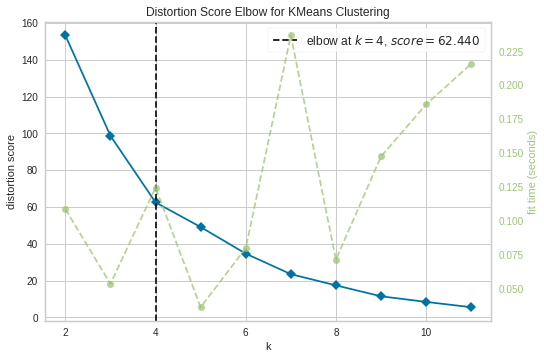

In [21]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_kmeams)
visualizer.show()
plt.show()

#KMeans

### Según esta validacion podemos ver que con 4 clusters serian suficiente para validar el comportamiento de las diferentes criptos, por lo que una vez obtenido el valor optimo de clusters, se entrena el modelo.

### Para la clusterización utilizaremos KMeans como herramienta principal, definiendole como parámetro de entrada la cantidad de clusters que hemos previamente definido.

In [22]:
km_4 = KMeans(n_clusters=4,n_init=25, random_state=123)
km_4.fit(df_kmeams)

list_of_centers = km_4.cluster_centers_[:,1].tolist()

In [23]:
df_km_kmeans = pd.DataFrame(columns=df_pivot.columns, data=[km_4.labels_])
df_km_kmeans

active,ADAUSDT,BNBUSDT,BTCUSDT,DASHUSDT,DOGEUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,LUNAUSDT,NEOUSDT,XMRUSDT,XRPUSDT
0,0,3,3,0,1,1,1,3,0,0,2,1,0,0


#### Luego de realizar la clusterización, podemos saber a qué grupo pertenece cada cripto por igualdad de comportamiento. Ahora vamos agregar este grupo al dataset donde se encuentra todas las columnas, asi podremos graficar si son grupos con comportamientos similares.  

In [24]:
contador = 0
for i in df_km_kmeans.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_km_kmeans[i][0]
    if contador == 0:
        df_cluster_kmeans = aux.copy()
        contador += 1
    else:
        df_cluster_kmeans = pd.concat([df_cluster_kmeans, aux])

df_cluster_kmeans

,profit,close,active,Scalar_close,Scalar_profit,cluster
Fecha,,,,,,
2019-01-01,0.753079,0.040842,ADAUSDT,0.005710,0.677493,0
2019-01-02,0.720690,0.043108,ADAUSDT,0.006474,0.674966,0
2019-01-03,-0.434108,0.042657,ADAUSDT,0.006322,0.584853,0
2019-01-04,0.362739,0.042685,ADAUSDT,0.006331,0.647034,0
2019-01-05,0.873916,0.043920,ADAUSDT,0.006748,0.686923,0
...,...,...,...,...,...,...
2022-04-28,-0.304636,0.644417,XRPUSDT,0.308104,0.478368,0
2022-04-29,-0.525248,0.619367,XRPUSDT,0.292798,0.461983,0
2022-04-30,-0.841903,0.610050,XRPUSDT,0.287105,0.438465,0


### Validamos rapidamente cual seria la distribucion de cada cluster

In [25]:
df_cluster_kmeans.cluster.value_counts()

0    7134
1    4687
3    3654
2     620
Name: cluster, dtype: int64

In [26]:
aux0 = df_cluster_kmeans[df_cluster_kmeans.cluster == 0]
aux1 = df_cluster_kmeans[df_cluster_kmeans.cluster == 1]
aux2 = df_cluster_kmeans[df_cluster_kmeans.cluster == 2]
aux3 = df_cluster_kmeans[df_cluster_kmeans.cluster == 3]

#### Graficamos todos los cluster para verificar el comportamiento de cada grupo. 

### En las gráficas siguientes veremos que el precio de close escalado de las criptomonedas, en cada cluster, presentan patrones con algunas similitudes, donde se ven subidas y bajadas con pendientes similares en el mismo período de tiempo. 
### Existe un caso particular, en el cluster 2 donde solo exite un único criptoactivo, que es LUNA, ya que este presenta un comportamiento opuesto al del resto de criptomonedas. 

In [27]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [28]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 1 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()

In [29]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 2 (Escalado) ' +active,
    width=1100,
    height=600,
    )

fig.show()

In [30]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 3 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()


#MeanShift

### Evaluamos ahora con la función MeanShift, el cual es un algoritmo basado en centroides, que funciona actualizando candidatos para centroides para que sean la media de los puntos dentro de una región determinada. Estos candidatos luego se filtran en una etapa de posprocesamiento para eliminar casi duplicados para formar el conjunto final de centroides.

### A diferencia de KMeans, MeanShift no necesita conocer le número de grupos que se van a clusterizar como dato previo. 


In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth
df_MeanShift = df_kmeams

In [32]:
bandwidth = estimate_bandwidth(df_MeanShift, quantile=0.2, n_samples=500)

In [33]:
ms = MeanShift(bandwidth=bandwidth)

ms.fit(df_MeanShift)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

y_pred  = ms.predict(df_MeanShift)

Cantidad de clusters encontrados por Mean Shift : 8


###En este caso, vemos que Mean Shift identifica que en la base de datos existen 8 nodos, en lugar de 4 como hemos visto anteriormente. 

Text(0, 0.5, 'Feature 2')

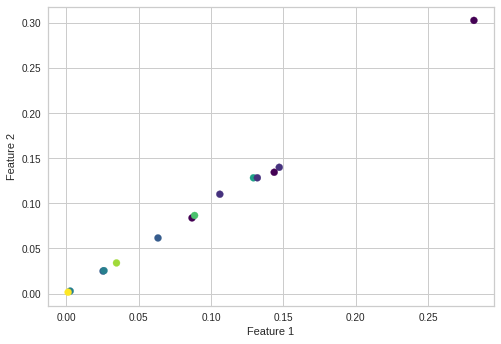

In [34]:
plt.scatter(df_MeanShift[:, 0], df_MeanShift[:, 1], c=y_pred, cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Clustering Jerarquico

###El Clustering Jerarquico es un tipo de algoritmo de Aprendizaje no Supervisado que se utiliza para agrupar puntos de datos no etiquetados. La Agrupación Jerárquica también agrupa los puntos de datos con características similares.

####Existen dos tipos de Agrupación Jerárquica: aglomerativa y divisoria. En el primero, los puntos de datos se agrupan utilizando un enfoque ascendente que comienza con puntos de datos individuales, mientras que en el segundo se sigue un enfoque descendente en el que todos los puntos de datos se tratan como un gran conglomerado y el proceso de agrupación implica la división de un gran conglomerado en varios conglomerados pequeños.

####El objeto, de Scikit Learn, AgglomerativeClustering realiza una agrupación jerárquica utilizando un enfoque de abajo hacia arriba, cada observación comienza en su propio cúmulo, y los cúmulos se fusionan sucesivamente.

In [35]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy as  shc

AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

AgglomerativeClustering()

In [36]:
df_pivot_Jerarq = df_pivot.reset_index()

In [37]:
df_pivot_Jerarq.drop('index', axis='columns', inplace=True)

In [38]:
df_pivot_Jerarq_trans = df_pivot_Jerarq
df_pivot_Jerarq_trans = df_pivot_Jerarq_trans.T
df_pivot_Jerarq_trans

,0,1,2,3,4,5,6,7,8,9,...,610,611,612,613,614,615,616,617,618,619
active,,,,,,,,,,,,,,,,,,,,,
ADAUSDT,0.034718,0.033898,0.032958,0.033871,0.031302,0.030452,0.028425,0.028711,0.030434,0.031017,...,0.294061,0.290690,0.284599,0.280615,0.274862,0.275676,0.266046,0.257196,0.253696,0.255584
BNBUSDT,0.025430,0.024850,0.024498,0.025449,0.024522,0.025072,0.025643,0.026035,0.026577,0.026869,...,0.604738,0.599507,0.591850,0.587377,0.582930,0.600821,0.593493,0.583511,0.575728,0.580984
BTCUSDT,0.129307,0.128316,0.128553,0.130395,0.125858,0.125177,0.123967,0.125986,0.126956,0.128635,...,0.567360,0.566185,0.564589,0.560274,0.556335,0.567032,0.554641,0.546482,0.543596,0.554350
DASHUSDT,0.131997,0.128325,0.130803,0.134528,0.122954,0.120144,0.114889,0.117467,0.119484,0.124450,...,0.164532,0.157808,0.149791,0.148455,0.143885,0.148282,0.142204,0.132808,0.125868,0.129273
DOGEUSDT,0.002737,0.002697,0.002697,0.002693,0.002554,0.002516,0.002421,0.002437,0.002513,0.002514,...,0.195266,0.191651,0.205599,0.215760,0.202814,0.200322,0.198051,0.191675,0.190283,0.190234
EOSUSDT,0.147109,0.139951,0.140684,0.146032,0.130170,0.120851,0.110951,0.118161,0.124456,0.130995,...,0.054507,0.049724,0.043205,0.040546,0.036800,0.042248,0.040335,0.028692,0.019060,0.021995
ETCUSDT,0.026098,0.025356,0.025575,0.026371,0.024353,0.023424,0.023379,0.023908,0.024190,0.024186,...,0.254196,0.247524,0.236264,0.230134,0.223137,0.223259,0.212405,0.199211,0.190157,0.193987
ETHUSDT,0.063377,0.061600,0.061326,0.063884,0.060872,0.060055,0.059761,0.061736,0.063607,0.066907,...,0.609689,0.605360,0.601712,0.598743,0.592623,0.602229,0.588083,0.576522,0.574487,0.583822
LINKUSDT,0.281567,0.302865,0.293664,0.297834,0.285539,0.288352,0.288041,0.293323,0.319997,0.331774,...,0.262133,0.260095,0.254314,0.249937,0.245159,0.245493,0.236940,0.225446,0.215288,0.215790


###A continuación se presentará el dendograma, donde al utilizar un clustering aglomerativo, el enfoque del mismo será de abajo hacia arriba (bottom up). Es decir, partiremos de 14 clusters separados (cada uno es una criptomoneda) que se aglomerarán hasta llegar a 2. 



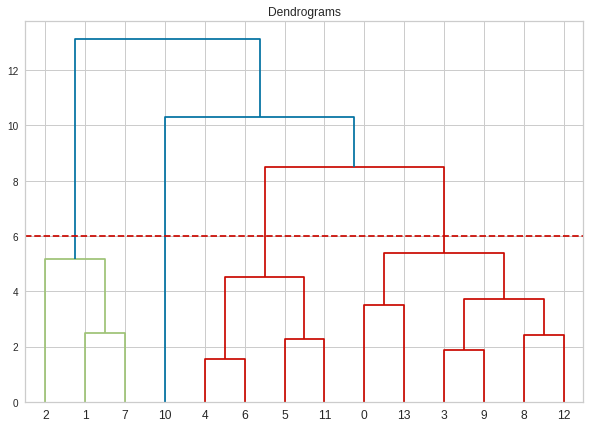

In [39]:
plt.figure(figsize=(10, 7))  

plt.title("Dendrograms")

z = shc.linkage(df_pivot_Jerarq_trans, method='ward')

dend = shc.dendrogram( z )

plt.axhline(y=6, color='r', linestyle='--')

plt.show()

### Procederemos a hacer un corte de la aclomeración cuando se hayan obtenido un total de 4 clusters. Luego, graficaremos cada agrupación a fin de buscar similitudes entre las criptomonedas clusterizadas. 

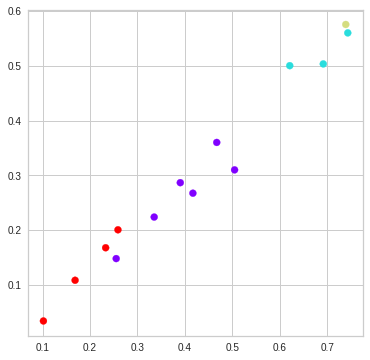

In [40]:
ac2 = AgglomerativeClustering(n_clusters = 4)

#Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(df_pivot_Jerarq_trans[513], df_pivot_Jerarq_trans[520],
          c = ac2.fit_predict(df_pivot_Jerarq_trans), cmap ='rainbow')
plt.show()

In [41]:
c = ac2.fit_predict(df_pivot_Jerarq_trans)
list_of_centers = ac2.labels_.tolist()

In [42]:
df_Jerarq = pd.DataFrame(columns=df_pivot.columns, data=[ac2.labels_])
df_Jerarq

active,ADAUSDT,BNBUSDT,BTCUSDT,DASHUSDT,DOGEUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,LUNAUSDT,NEOUSDT,XMRUSDT,XRPUSDT
0,0,1,1,0,3,3,3,1,0,0,2,3,0,0


In [43]:
contador = 0
for i in df_Jerarq.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_Jerarq[i][0]
    if contador == 0:
        df_cluster_Jerarq = aux.copy()
        contador += 1
    else:
        df_cluster_Jerarq = pd.concat([df_cluster_Jerarq, aux])

df_cluster_Jerarq

,profit,close,active,Scalar_close,Scalar_profit,cluster
Fecha,,,,,,
2019-01-01,0.753079,0.040842,ADAUSDT,0.005710,0.677493,0
2019-01-02,0.720690,0.043108,ADAUSDT,0.006474,0.674966,0
2019-01-03,-0.434108,0.042657,ADAUSDT,0.006322,0.584853,0
2019-01-04,0.362739,0.042685,ADAUSDT,0.006331,0.647034,0
2019-01-05,0.873916,0.043920,ADAUSDT,0.006748,0.686923,0
...,...,...,...,...,...,...
2022-04-28,-0.304636,0.644417,XRPUSDT,0.308104,0.478368,0
2022-04-29,-0.525248,0.619367,XRPUSDT,0.292798,0.461983,0
2022-04-30,-0.841903,0.610050,XRPUSDT,0.287105,0.438465,0


In [44]:
df_cluster_Jerarq.cluster.value_counts()

0    7134
3    4687
1    3654
2     620
Name: cluster, dtype: int64

In [45]:
aux0 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 0]
aux1 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 1]
aux2 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 2]
aux3 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 3]

###De igual forma que con KMeans, procederemos a graficar cada uno de los clusters que se obtuvieron de aplicar un Clustering Jerárquico. En las gráficas veremos que la agrupación que se ha obtenido es exactamente igual a la de KMeans. 
###Aplicando ambos métodos podemos ver algunos ejemplos tales como LUNA, que se separa del resto de criptomonedas debido a su comportamiento contrario a todas las demás y además tenemos un grupo donde se encuentran las tres monedas con mayor volumen del mercado, que son BTC, ETH y BNB. 


In [46]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [47]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 1 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [48]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 2 (Escalado) '+ active,
    width=1100,
    height=600,
    )

fig.show()

In [ ]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 3 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()

# Conclusión

Como conclusión final, vemos que los clusters agrupan criptomonedas en base a multiples factores, pero viendo los gráficos de cada cluster, podemos concluir que la tendencia de cada una de estas criptomonedas por cluster tienen cierta correlación. A su vez, podemos ver que LUNA, que tiene un comportamiento distinto de las demas criptomonedas, como se muestra en KMeans y en clustering jerárquico, está agrupada en un cluster separada del resto, por lo que es otro indicio de que estos clusters tuvieron una buena performance agrupando los activos. Por otro lado, si analizamos el cluster 3, vemos que se encuentran BTC, ETH y BNB, que son las 3 criptomonedas con más capitalización de mercado y con un rendimiento similar una a otra.
A futuro, podriamos realizar algunos cluster utilizando otros features como indicadores técnicos, para ver si podemos encontrar alguna otra relación entre las cripto que a simple vista no se pueda ver.

# Desarrollo Parte 2

Deformación dinámica del tiempo, en inglés conocida como  "dynamic time warping"  es un algoritmo para medir la similitud entre dos secuencias temporales que permite obtener un buen ajuste incluso frente a un desfase en la velocidad o en el tiempo. 

Para el análisis datasets que dependan de series temporales, utilizar algoritmos clustering donde se miden distancias entre datos, como por ejemplo la distancia Euclidea, no siempre son apropiados para este tipo de bases de datos, ya que es invariable a los cambios de tiempo, ignorando la dimensión temporal de los datos. Si dos series temporales están muy correlacionadas, pero una de ellas se desplaza incluso un paso de tiempo, la distancia euclidiana las mediría erróneamente como más alejadas. 

Un enfoque mejor es sustituir la medida de distancia por defecto por una métrica para comparar series temporales, como por ejemplo Deformación dinámica del tiempo, en inglés conocida como  "dynamic time warping"  es un algoritmo para medir la similitud entre dos secuencias temporales que permite obtener un buen ajuste incluso frente a un desfase en la velocidad o en el tiempo.El
Dynamic Time Warping es una técnica que mide la similitud entre dos series temporales que no necesariamente están exactamente alineadas en el tiempo.


## Evaluamos distancia euclídea

### Comenzaremos midiendo la distancia euclidea entre cada uno de los activos. En este caso tomaremos df_kmeams que fue convertido en un array de dos dimensiones, de 14 filas (cantidad de criptomonedas) por 620 columnas (valor del activo en cada período). 
### Para mayor facilidad de compresión del lector, el array devuelto se debe leer de la siguiente manera: 


1.   Cada fila representa un activo contra sí mismo y contra el resto de activos
2.   Al medirse un activo con el mismo, la distancia es nula, es por ello que aparece un 0.
3. Los activos estan ordenados de la misma forma que los datasets de este trabajo, que son en el siguiente orden: ADAUSDT,	BNBUSDT,	BTCUSDT,	DASHUSDT,	DOGEUSDT,	EOSUSDT,	ETCUSDT,	ETHUSDT,	LINKUSDT,	LTCUSDT,	LUNAUSDT,	NEOUSDT,	XMRUSDT,	XRPUSDT.



In [64]:
from scipy.spatial.distance import pdist, squareform
euclidean_dist = squareform(pdist(df_kmeams,'euclidean'))
print (euclidean_dist)

[[ 0.          4.96926362  6.31298366  4.98397289  5.26799722  6.66836555
   4.72558475  4.56603086  4.69186052  4.56566808  8.05506047  5.58760499
   4.03346949  3.49291007]
 [ 4.96926362  0.          4.87912852  7.21491209  7.74801345  9.40587629
   7.43633538  2.47178053  5.90943111  6.27122658  8.04340112  7.9078479
   5.23595303  4.59699139]
 [ 6.31298366  4.87912852  0.          7.70527823  9.88317081 10.56627324
   9.56049033  4.40411701  5.05689274  6.44906517 10.27541632  8.96033293
   5.58105004  6.43573969]
 [ 4.98397289  7.21491209  7.70527823  0.          4.18555119  3.3071129
   4.43363543  7.45443808  3.53140985  1.86282366  8.53187728  1.93260698
   3.23346725  3.89888862]
 [ 5.26799722  7.74801345  9.88317081  4.18555119  0.          3.23315605
   1.53239851  7.85795463  6.25296569  4.5898115   7.41947969  3.13737757
   5.10735531  4.50850023]
 [ 6.66836555  9.40587629 10.56627324  3.3071129   3.23315605  0.
   3.75607145  9.5187623   6.20287423  4.37832497  8.75321765

#Aplicación de DTW

### Para el mismo array ahora aplicaremos el Dynamic Time Warping (DTW). El modo de leer el array de distancias es el mismo que el explicado en el caso de "euclidean_dist". Se puede notar que en este caso, las distancias entre activos son disferentes, presentando valores más pequeños que en el caso de mediciones euclideas. 

In [ ]:
!pip install dtaidistance

In [75]:
from dtaidistance import dtw
dtw_scorex = dtw.distance_matrix_fast(df_kmeams)
dtw_scorex

array([[0.        , 2.88621787, 2.74396532, 1.57875527, 1.03943853,
        2.56875816, 1.18982544, 2.78082797, 2.18521311, 1.13863741,
        3.78038771, 1.82917788, 1.39541367, 1.59096036],
       [2.88621787, 0.        , 1.09537784, 5.30475203, 5.13081441,
        7.32435161, 4.68327492, 0.67442387, 3.84122302, 4.08417009,
        1.48410221, 6.02122707, 3.08023762, 2.75864175],
       [2.74396532, 1.09537784, 0.        , 5.03738011, 5.17461881,
        7.26972104, 4.61499963, 0.75055731, 3.26295681, 3.95573837,
        2.03825048, 5.80583304, 2.75520388, 2.65118738],
       [1.57875527, 5.30475203, 5.03738011, 0.        , 1.28180137,
        1.2965311 , 1.28242561, 5.03236182, 1.46276826, 0.86290634,
        5.66389501, 0.81022348, 2.08604838, 1.56533698],
       [1.03943853, 5.13081441, 5.17461881, 1.28180137, 0.        ,
        1.82737173, 0.68232009, 4.95818764, 2.62094394, 1.16746304,
        5.35103187, 1.43623788, 2.22308311, 1.84051162],
       [2.56875816, 7.32435161, 7.2